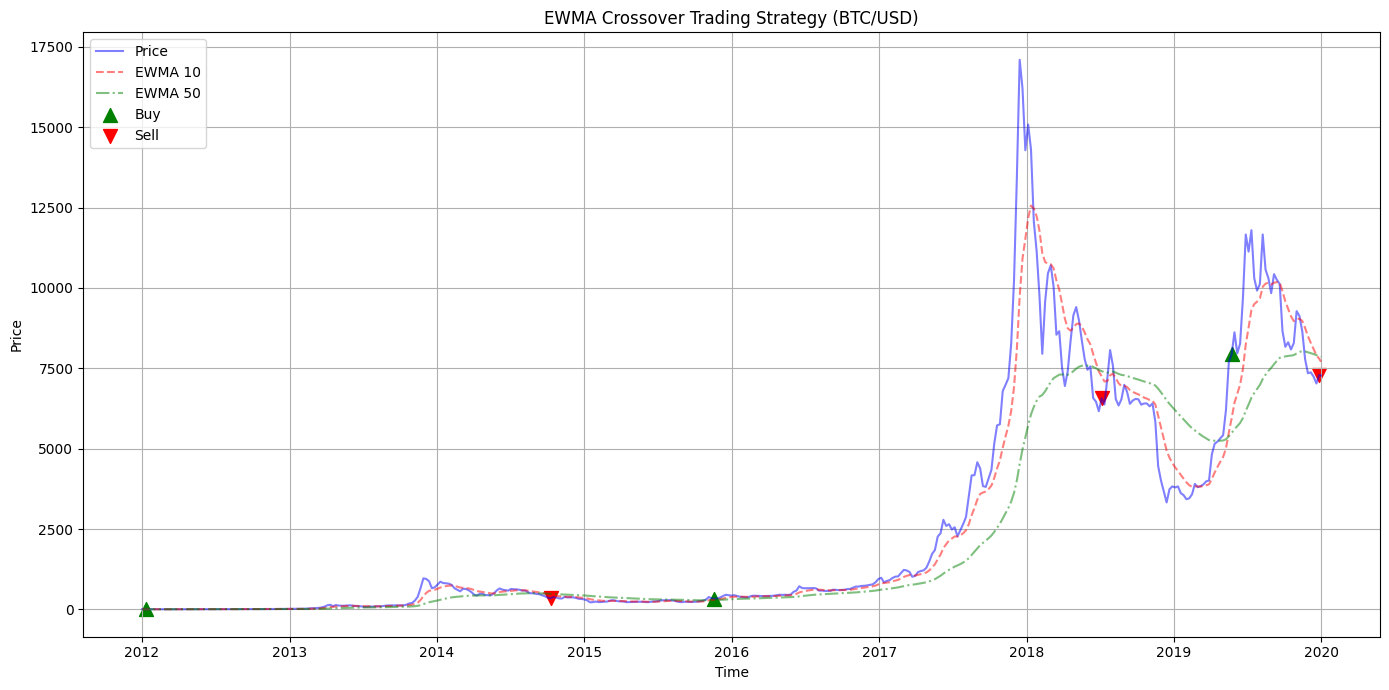

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_ewma(series, span):
    alpha = 2 / (span + 1)
    ewma = [series.iloc[0]]  # Initialize with first price
    for price in series.iloc[1:]:
      new_ewma = alpha * price + (1 - alpha) * ewma[-1]
      ewma.append(new_ewma)
    return pd.Series(ewma, index=series.index)

def generate_signal(df):
  # Generate signals based on crossover condition
  # if short term signal crosses above the logn term signal (short > long) buy (1)
  # if short term signal crosses below the logn term signal (short < long) sell (-1)

  # initialize signal as 0
  df['Signal'] = 0

  # populating the signals based on the crossover conditions
  df['Signal'] = np.where(
      df['EWMA_short'] > df['EWMA_long'], 1, -1
  )

  # shifting the signal to avoid
  df['Position'] = df['Signal'].shift(1)

  # Detect crossover points based on shift in long term trend
  df['Crossover'] = df['Position'].diff()

  # Buy signal: change from -1 to 1 -> diff = 2
  buy = df[df['Crossover'] == 2]

  # Sell signal: change from 1 to -1 -> diff = -2
  sell = df[df['Crossover'] == -2]

  return buy, sell


# loading and resampling data by frequency of the week
df = pd.read_csv("btcusd_1-min_data.csv", parse_dates=['datetime'])
df.set_index('datetime', inplace=True)

train_df = df[df.index < '2020-01-01']
test_df = df[df.index >= '2020-01-01']

train_df_week = train_df.resample('W').mean()
test_df_week = test_df.resample('W').mean()

# Load your real dataset
df = train_df_week

# Converting the timestamp to date
if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    df.set_index('Timestamp', inplace=True)

# Renaming close column as price
df = df[['Close']].dropna().copy()
df.rename(columns={'Close': 'Price'}, inplace=True)

# creating the short ewma
df['EWMA_short'] = compute_ewma(df['Price'], span=10)

# Creating the long ewma
df['EWMA_long'] = compute_ewma(df['Price'], span=50)

buy, sell = generate_signal(df)

plt.figure(figsize=(14, 7))
plt.plot(df['Price'], label='Price', alpha=0.5, color = 'blue')
plt.plot(df['EWMA_short'], label='EWMA 10', alpha=0.5, color='red',linestyle='--')
plt.plot(df['EWMA_long'], label='EWMA 50', alpha=0.5, color='green', linestyle='-.')
plt.scatter(buy.index, buy['Price'], marker='^', color='green', label='Buy', s=100)
plt.scatter(sell.index, sell['Price'], marker='v', color='red', label='Sell', s=100)
plt.title('EWMA Crossover Trading Strategy (BTC/USD)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()